In [1]:
using Pkg;
using LSHFunctions
#using StaticArrays
using DataStructures
using Flux
using Zygote
using MLDatasets
using ImageView
using LinearAlgebra
using Plots;

In [2]:
# load full training set
train_x, train_y = MNIST.traindata();
#train_x = permutedims(train_x,[3,2,1])
#train_y = permutedims(train_y,[3,2,1])

In [3]:
train_x = permutedims(train_x,(3,2,1))
x_train = reshape(train_x,(size(train_x)[1],prod(size(train_x)[2:end])));

5


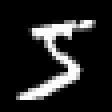

In [4]:
println(train_y[1])
Gray.(train_x[1,:,:])


In [5]:
function comb(n, len) 
    Iterators.product(fill(BitArray([0,1]), len)...) |> collect |> vec 
end

comb (generic function with 1 method)

In [6]:
#Parameters
const batch_size = 16
const k = 6
const L = 5
const sample_rate = 0.1 # 1%, proportion of nodes to sample from matrix

0.1

In [7]:
all_hash_codes = comb(1,k); #create all possible hash codes 2^k = 2^6 = 64

In [8]:
# Each layer is associated with `L` hash-tables and therefore `L` hash functions
mutable struct Layer
    theta::Matrix{Float64}
    bias::Matrix{Float64}
    hash_funs::Vector{SimHash{Float32}}
    hash_tables::Vector{Dict{Tuple,CircularBuffer{Int64}}}
end

In [9]:
function gen_layer(in_dim,out_dim,k=6,L=6,bin_size=10)
    theta = randn(in_dim,out_dim) / 2
    bias = randn(1,out_dim) / 5
    cols = size(theta)[2] #number of columns/nodes
    hash_funs = [LSHFunction(cossim, k) for i in 1:L]
    hash_tables = Vector{Dict{Tuple,CircularBuffer{Int64}}}()
    for i in 1:L #create L hash tables
        ht_l::Dict{Tuple,CircularBuffer{Int64}} = Dict{Tuple,CircularBuffer{Int64}}((x) => CircularBuffer{Int64}(bin_size) for x in all_hash_codes)
        push!(hash_tables,ht_l)
        for j in 1:cols
            hash_lj = hash_funs[i](theta[:,j])
            hash_lj = Tuple(hash_lj)
            push!(hash_tables[i][hash_lj],j)
        end
    end
    layer = Layer(theta,bias,hash_funs,hash_tables)
    return layer
end

gen_layer (generic function with 4 methods)

In [10]:
function update_htables(layer::Layer)
    num_ht = length(layer.hash_funs)
    cols = size(layer.theta)[2]
    for i in 1:num_ht #iterate tables
        for j in 1:cols
            hash_lj = layer.hash_funs[i](layer.theta[:,j])
            hash_lj = Tuple(hash_lj)
            push!(layer.hash_tables[i][hash_lj],j)
        end
    end
end

update_htables (generic function with 1 method)

In [42]:
layer1 = gen_layer(784,512)
layer2 = gen_layer(512,10)
layers = [layer1,layer2];

In [12]:
function get_batch(X, Y; batch_size=16)
    indices = rand(1:size(X)[1],batch_size)
    batch_x = X[indices,:]
    batch_y = Y[indices]
    return batch_x,batch_y
end

get_batch (generic function with 1 method)

In [13]:
batch_x,batch_y = get_batch(x_train, train_y; batch_size=1);

In [14]:
# hash_funs::Vector{SimHash{Float32}}
# hash_tables::Vector{Dict{Tuple,CircularBuffer{Int64}}}
function sample_nodes(query::Vector, layer::Layer)
    #`query` is the input vector for this layer
    S = Set{Int64}()
    for i in 1:L
        # compute hash of query using each hashfun
        q_hash = layer.hash_funs[i](query) |> Tuple
        matches = layer.hash_tables[i][q_hash]
        union!(S,matches)
    end
    return S |> collect
end

sample_nodes (generic function with 1 method)

In [15]:
function run_layer(X::Matrix,layer::Layer, cols::Vector{Int64}, rows::Vector{Int64})
    #S is the subset
    #println("$(size(X))  $(size(layer.theta[:,S]))  $(size(layer.bias))")
    e1 = isempty(cols)
    e2 = isempty(rows)
    bias = e1 ? layer.bias : layer.bias[:,cols]
    theta = e1 ? layer.theta : layer.theta[:,cols]
    #println(size(bias),size(theta))
    theta = e2 ? theta : theta[rows,:]
    #println(size(bias),size(theta))
    #println(size(bias))
    y_ = X * theta .+ bias #e.g. 1x784 * 784x36 = 1x36 + 1x36
    #println(size(y_))
    #println(y_)
    #y = reshape(y_,1,:)
    #println(size(y),size(y_))
    return y_, cols
end

run_layer (generic function with 1 method)

1×10 Matrix{Float64}:
 0.0285057  0.0750486  0.0815438  0.180232  …  0.0360265  0.113545  0.397267

In [39]:
function model(X::Array,layers::Vector{Layer}, S::Vector)
    #layer-1
    A1, c1 = run_layer(X,layers[1],S,Vector{Int64}([]))
    A1 = Flux.normalise(A1;dims=ndims(A1), ϵ=1e-5)
    A1 = NNlib.relu.(A1)
    #layer-2
    A2, c2 = run_layer(A1,layers[2],Vector{Int64}([]),c1)
    A2 = Flux.normalise(A2;dims=ndims(A2), ϵ=1e-5)
    A2 = NNlib.softmax(A2,dims=2)
    return A2#,A1,S
end

model (generic function with 1 method)

In [40]:
#run_layer(batch_x,layers[1],sort([x for x in S]),Vector{Int64}([]))
model(batch_x, layers, [1,50,90,112,145,240,300,301,500,505])

1×10 Matrix{Float64}:
 0.0285057  0.0750486  0.0815438  0.180232  …  0.0360265  0.113545  0.397267

In [35]:
lossfn(ŷ::Vector{Float64},y::Vector{Float64}) = -1.0 * LinearAlgebra.dot(log.(ŷ),y)

lossfn (generic function with 1 method)

In [36]:
#Y_true = Vector{Float64}(Flux.onehotbatch(train_y[1],0:9));
function fix_label(y)
    t = zeros(Float64,10)
    t[y[]+1] = 1.0
    return t
end

fix_label (generic function with 1 method)

In [37]:
fix_label(batch_y)

10-element Vector{Float64}:
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

##### Calculating the gradients

$$\frac{\partial Loss}{\partial \hat{y}} = $$

In [49]:
batch_x,batch_y = get_batch(x_train,train_y;batch_size=1);
S = sample_nodes(vec(batch_x),layers[1])
A2 = model(batch_x,layers,S)
y_true = fix_label(batch_y)
g = Zygote.gradient(w -> lossfn(vec(model(rand(1,784),w,S)),[1.0,0,0,0,0,0,0,0,0,0]),layers)
#g = Zygote.gradient((ypred,ytrue) -> lossfn(ypred,ytrue),(A2,batch_y))
#println(g);

LoadError: UndefVarError: xs not defined

In [ ]:
g[1][1][][:theta]

In [ ]:
[x for x in g[1][2]]

In [ ]:
lossfn(vec(model(batch_x,layers,S)),y_true)

In [ ]:
#batch_x,batch_y = get_batch(x_train,train_y;batch_size=1);
#S = sample_nodes(vec(batch_x),layers[1])
#A2,A1,S = model(batch_x,layers,S)
#err = lossfn(A2,batch_y)
W, b = randn(2, 3), randn(2);
x = [-1.0,2,3]
predict(W,b,x) = W*x .+ b;
g = Zygote.gradient(x -> sum(predict(W,b,x)),)
println(g)

In [ ]:
size(g[1])

In [ ]:
function train(epochs:Int64)
    for i in 1:epochs
        batch_x,batch_y = get_batch(x_train,train_y;batch_size=1);
        S = sample_nodes(vec(X),layers[1])
        A2,A1,S = model(batch_x,layers,S)
        err = lossfn(A2,batch_y)
        
    end
end

In [ ]:
((x,y) -> x+y)(1,2)

In [ ]:
batch = get_batch(train_x)

In [ ]:
batch = reshape(batch,(16,784))

In [ ]:
collect(S)

In [ ]:
size(batch * layer1.theta[:,S])